# Intro

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats1_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats1_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(28640, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((28640,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 676)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

14.553084

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.19786212

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
28640


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[124 124 124 124 124]
 [  3 658 478 440 967]
 [982 481 955 775 528]
 [  9 333 333 333 613]
 [ 21  21  21  21  21]]
[[124]
 [  3]
 [982]
 [  9]
 [ 21]]
[[0.9999999  0.79639614 0.7573937  0.7389341  0.72462726]
 [1.         0.8404213  0.81669426 0.78183615 0.7749489 ]
 [1.         0.75408095 0.7284549  0.69835955 0.68455404]
 [1.         0.787472   0.7221261  0.69110686 0.6417128 ]
 [0.99999994 0.90959346 0.8841326  0.8493742  0.8478177 ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57520,), (57520,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([ 66, 432, 948, 326, 451, 515, 308, 769, 303, 830]),
 array([ 66, 432, 948, 326, 451, 515, 308, 769, 303, 830]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([ 521,  590,  258, 1027,  199,  327,  622,  315,  432,  837]),
 array([ 521,  590,  258, 1027,  199,  327,  622,  315,  432,  837]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

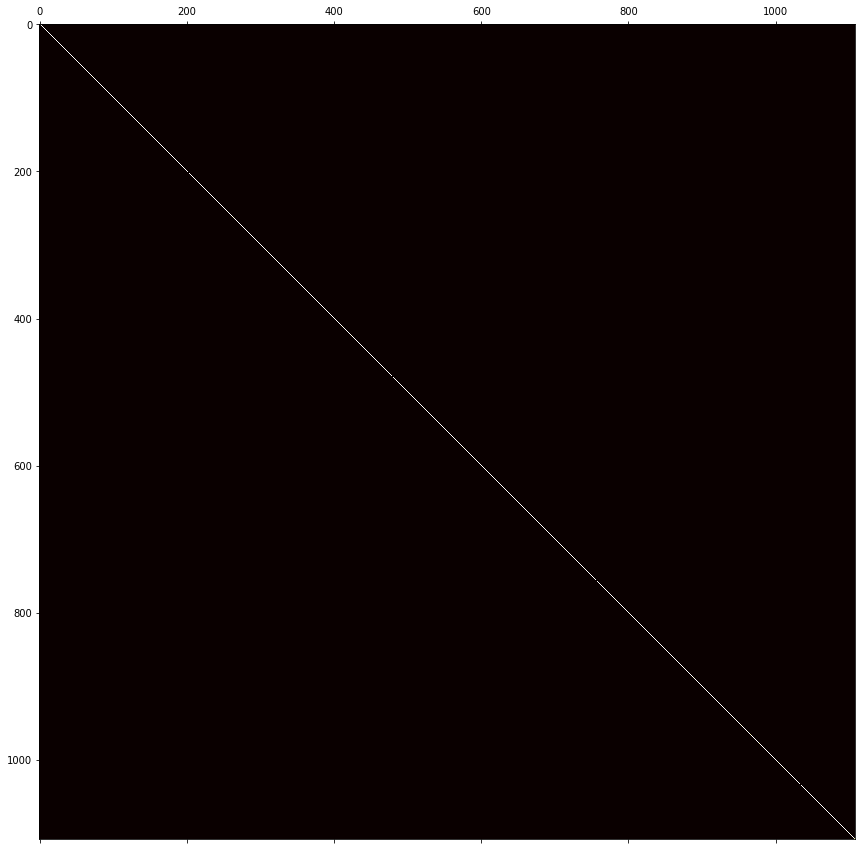

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [17]:
xq.max()

12.072606

In [18]:
faiss.normalize_L2(xq)

In [19]:
xq.max()

0.21168175

In [20]:
D_valid, I_valid = index.search(xq, k) # actual search

In [21]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [22]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [23]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 284  315  659  856  856]
 [ 618  699  542  222 1006]
 [ 964  964  964  964  668]
 [ 504  857  860 1000    9]
 [ 961  961  961  719  648]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.8208144  0.7405964  0.6830097  0.6737251  0.6727158 ]
 [0.5874394  0.507218   0.46220332 0.45664477 0.45333964]
 [0.75224876 0.69979227 0.69668686 0.69179    0.6907649 ]
 [0.6604495  0.5635783  0.56068647 0.560453   0.55952173]
 [0.6167942  0.60069275 0.5705944  0.5627043  0.5597233 ]]


In [24]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 277  970  388  277  277]
 [ 285  713  375  202 1010]
 [ 684  684  684  684  928]
 [ 519  616  677  238  186]
 [ 253 1029  463  314 1022]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.65519625 0.6445048  0.6335293  0.63343924 0.6296851 ]
 [0.70606935 0.6259628  0.6193743  0.59861255 0.5431895 ]
 [0.63706505 0.5807494  0.57609445 0.57050186 0.5408281 ]
 [0.80068094 0.79149485 0.7541588  0.73447806 0.72727   ]
 [0.7319426  0.7054286  0.69747823 0.601457   0.5343927 ]]


In [31]:
#np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [25]:
I_valid[:,0]

array([284, 618, 964, ..., 684, 519, 253])

In [26]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [27]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

1321

In [28]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.08535797363659861

In [29]:
valid_correct = np.equal(I_valid[:,0], yq)

In [30]:
valid_correct

array([False, False, False, ..., False, False, False])

In [38]:
#np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [31]:
cm = confusion_matrix(I_valid[:,0], yq)

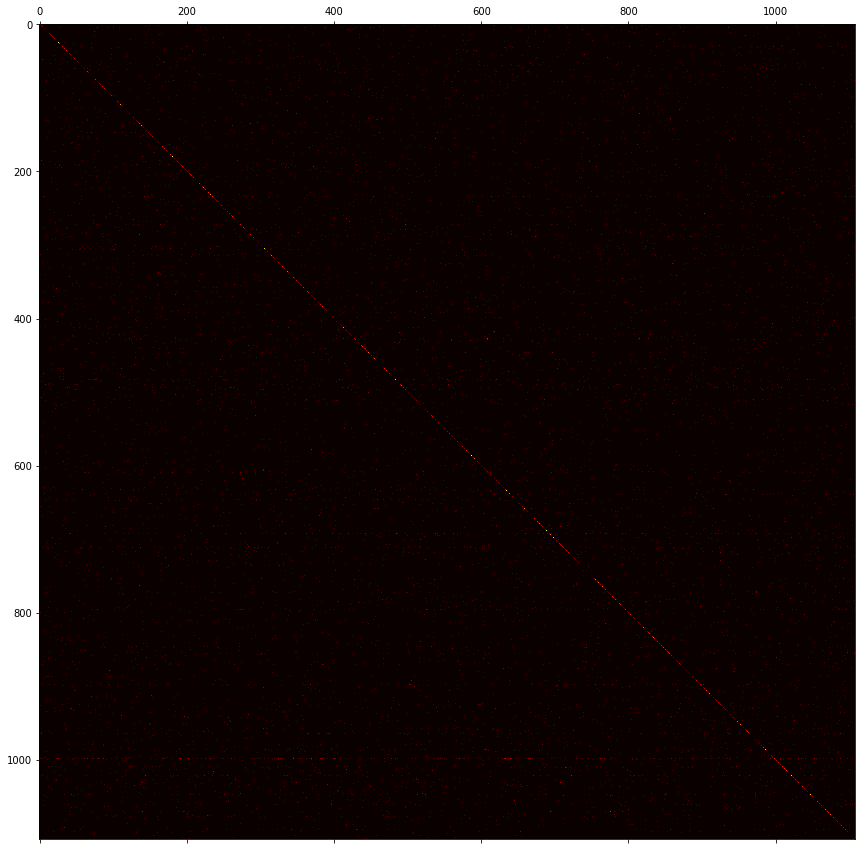

In [32]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [33]:
xq_test = np.load('pred/feats1_test.npy')

In [34]:
xq_test.max()

14.33381

In [35]:
faiss.normalize_L2(xq_test)

In [36]:
xq_test.max()

0.20417997

In [37]:
D_test, I_test = index.search(xq_test, k) # actual search

In [38]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [39]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[1047 1003 1047 1003 1003]
 [ 192  892  192  482  736]
 [ 484  484  484  484  484]
 [ 129  166  609   49  957]
 [ 693 1047 1047 1003 1003]]
[[0.74199003 0.68960893 0.6777214  0.63901997 0.6295294 ]
 [0.6457058  0.59311354 0.56162316 0.4920062  0.48120752]
 [0.6636753  0.64541745 0.6297393  0.6255569  0.6153996 ]
 [0.67548865 0.6588763  0.6505686  0.62401855 0.59544754]
 [0.64758104 0.6293149  0.58756804 0.5487386  0.54651296]]


In [40]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[ 426  941   17  941  912]
 [ 412  426  941  736  701]
 [  73  183   73   48  297]
 [1047 1003 1047 1047   52]
 [ 959  959  959  959  959]]
[[0.6072785  0.5641166  0.56321037 0.54991066 0.4950742 ]
 [0.55614126 0.54281044 0.50137895 0.48561922 0.46072218]
 [0.5805583  0.53178364 0.52827066 0.5268956  0.50530696]
 [0.6758279  0.67478096 0.64771163 0.64416105 0.64411664]
 [0.65815175 0.6450167  0.6425309  0.61525065 0.598318  ]]


In [41]:
I_test[2]

array([484, 484, 484, 484, 484])

In [42]:
np.unique(I_test[2], return_counts=True)

(array([484]), array([5]))

In [51]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [52]:
#np.save('pred/preds_test.npy', preds_test)
#np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)